<a href="https://colab.research.google.com/github/ridhsk/DeepFake-Detection/blob/main/models/ResNet50" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y pandas
!pip install pandas --no-cache-dir --upgrade

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 206.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
!pip install tensorflow opencv-python mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


In [ ]:
!cp -r "/content/drive/MyDrive/DeepFake Detection/dataset_resnet" /content/dataset_resnet


In [ ]:
import os
import glob
import re
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Enable mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# ✅ Your Dataset and Save Paths
DATASET_DIR = "/content/dataset_resnet"
CHECKPOINT_DIR = "/content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50/checkpoints"
FINAL_MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50/resnet_deepfake_model_final.keras"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
INITIAL_EPOCH = 0

# Data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake'],
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake'],
    shuffle=False
)

# 🔁 Resume from checkpoint if exists
checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, 'resnet_epoch_*.keras')))
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"🔁 Resuming from checkpoint: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    match = re.search(r'epoch_(\d+)', latest_checkpoint)
    if match:
        INITIAL_EPOCH = int(match.group(1))
else:
    print("🆕 No checkpoint found, building model from scratch...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'resnet_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Class weights
from sklearn.utils import class_weight
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# Save final model
model.save(FINAL_MODEL_PATH)
print(f"\n✅ Model saved to: {FINAL_MODEL_PATH}")

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
🔁 Resuming from checkpoint: /content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50/checkpoints/resnet_epoch_22_valacc_0.9160.keras


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2-2504824180.py", line 124, in <cell line: 0>
    class_weights = class_weight.compute_class_weight(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/class_weight.py", line 73, in compute_class_weight
    weight = recip_freq[le.transform(classes)]
             ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
IndexError: arrays used as indices must be of integer (or boolean) type

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/inter

TypeError: object of type 'NoneType' has no len()

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 517ms/step

📊 Classification Report:
              precision    recall  f1-score   support

        real       0.89      0.91      0.90       500
        fake       0.91      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


🧮 Confusion Matrix:


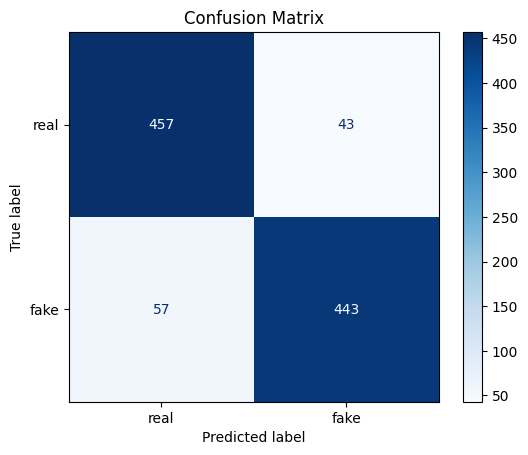

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Predict on Validation Set =====
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary class (0/1)

# True labels
true_labels = val_generator.classes

# ===== Classification Report =====
print("\n📊 Classification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=val_generator.class_indices.keys()
))

# ===== Confusion Matrix =====
print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step


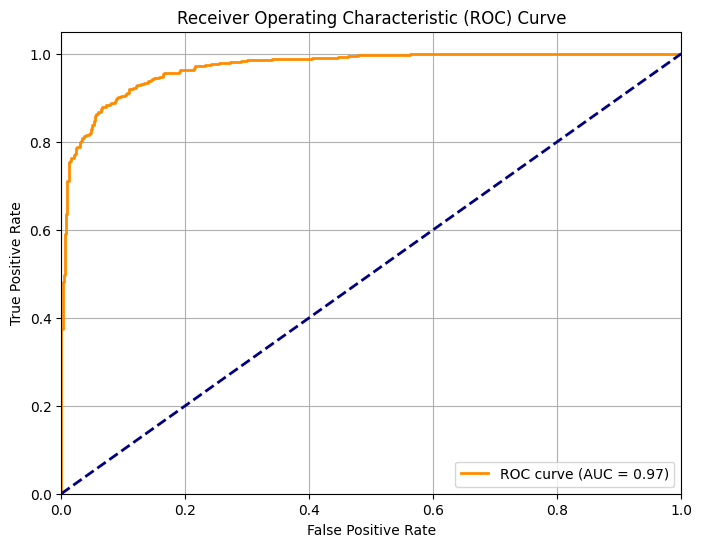

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities (already done)
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)

# True labels
true_labels = val_generator.classes

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


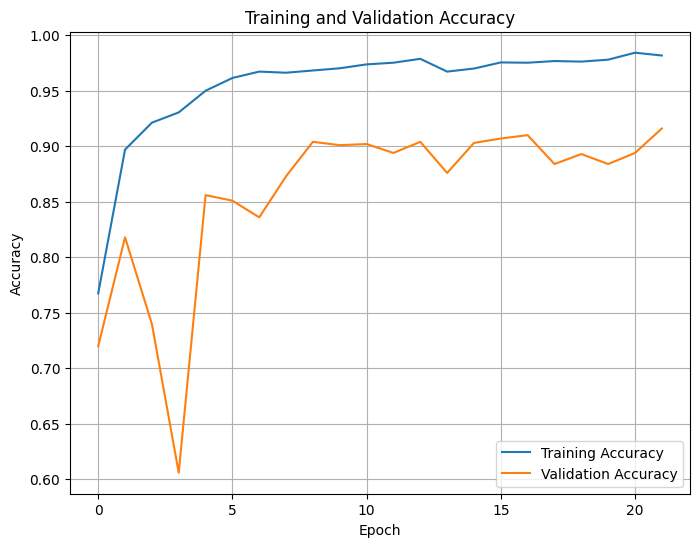

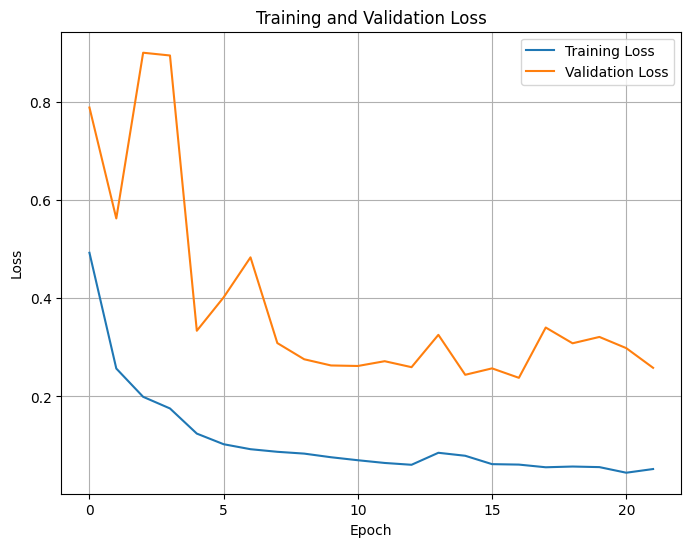

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
FINAL_MODEL_PATH = ""


Found 1000 images belonging to 2 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 498s 16s/step

🔍 Evaluation Metrics (ResNet50):
Accuracy:  0.5000
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
ROC AUC:   0.4435


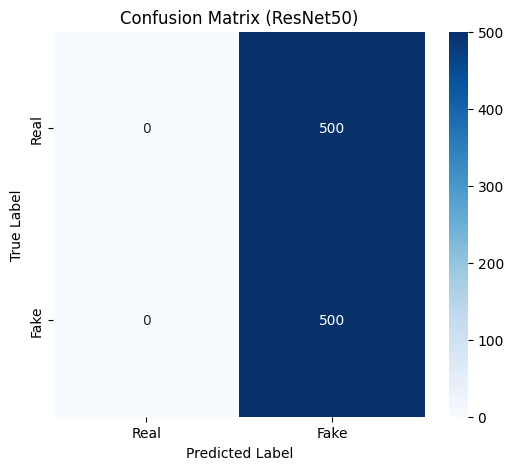

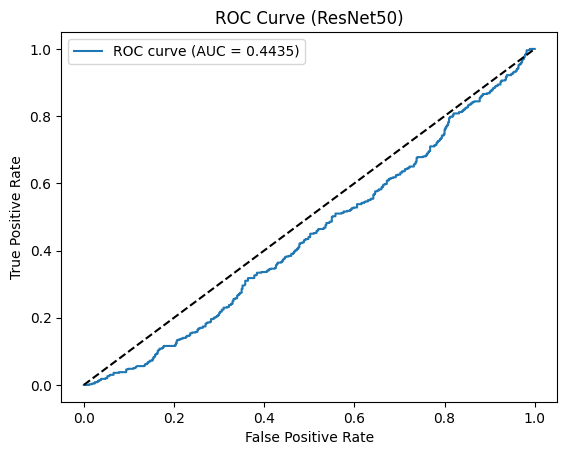

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50/resnet_deepfake_model_final.keras"
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset_resnet"
RESULTS_DIR = "/content/drive/MyDrive/DeepFake Detection/ResNet50_Eval"
IMG_SIZE = 224  # ResNet50 default
BATCH_SIZE = 32

# === Create results folder ===
os.makedirs(RESULTS_DIR, exist_ok=True)

# === Load Trained ResNet50 Model ===
model = load_model(MODEL_PATH)

# === Validation Data Generator ===
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),  # ResNet50 expects 224x224
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['real', 'fake']  # real=0, fake=1
)

# === Predictions ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

# Save metrics to file
with open(os.path.join(RESULTS_DIR, "metrics_report.txt"), "w") as f:
    f.write("ResNet50 Evaluation Metrics:\n")
    f.write(f"Accuracy:  {acc:.4f}\n")
    f.write(f"Precision: {prec:.4f}\n")
    f.write(f"Recall:    {rec:.4f}\n")
    f.write(f"F1 Score:  {f1:.4f}\n")
    f.write(f"ROC AUC:   {auc:.4f}\n")

print("\n🔍 Evaluation Metrics (ResNet50):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet50)")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"))
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet50)")
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"))
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 1999 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 812s 13s/step

🔍 Evaluation Metrics:
Accuracy:  0.9345
Precision: 0.9465
Recall:    0.9209
F1 Score:  0.9335
ROC AUC:   0.9861


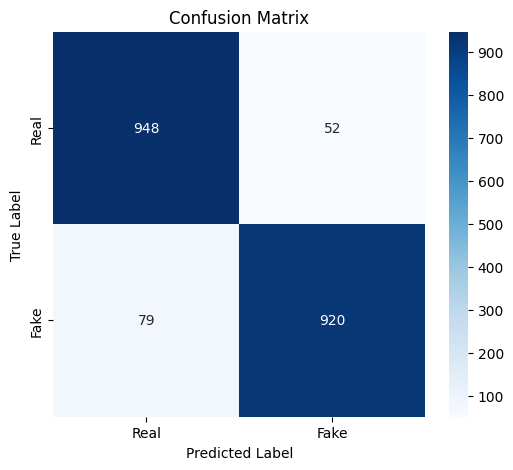

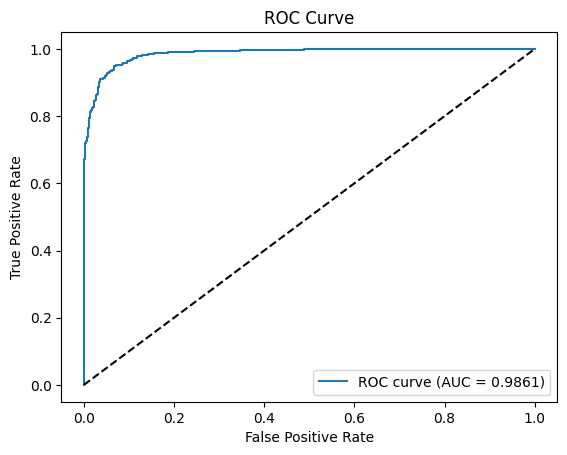

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50b/resnet_deepfake_model_final.keras"
DATASET_DIR="/content/drive/MyDrive/DeepFake Detection/dataset_resnet10frame"
IMG_SIZE = 224
BATCH_SIZE = 32

# === Load Model ===
model = load_model(MODEL_PATH)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['real', 'fake']  # real=0, fake=1
)

# === Predict ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

print("\n🔍 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 1999 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1539s 25s/step

🔍 Evaluation Metrics for ResNet-50:
Accuracy:          0.9350
Precision:         0.9466
Recall:            0.9219
F1 Score:          0.9341
ROC AUC:           0.9861
AUPRC:             0.9866
Log Loss:          0.1651
MCC:               0.8702
EER:               0.0630 (Threshold: 0.3814)
False Positive Rate: 0.0520
False Negative Rate: 0.0781


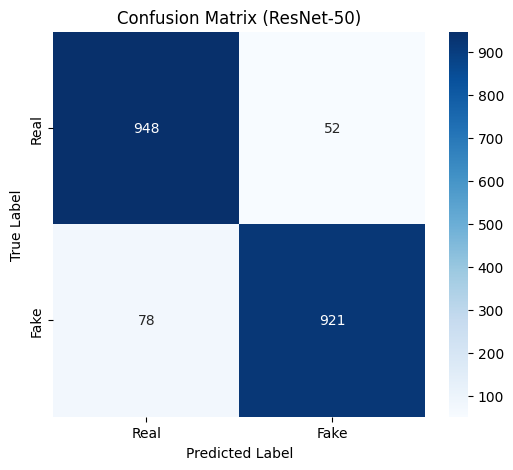

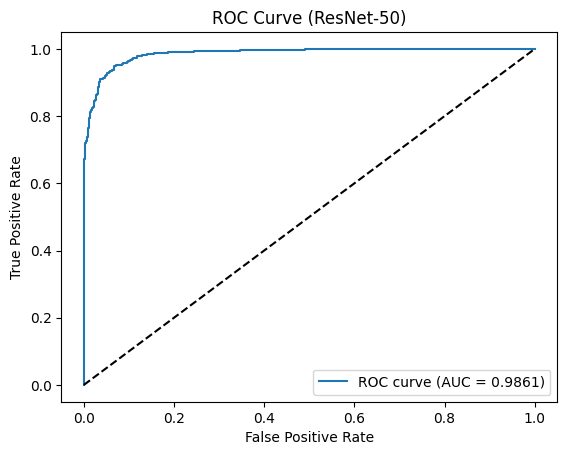

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, log_loss, matthews_corrcoef
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# === CONFIG ===
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Training the model/ResNet50b/resnet_deepfake_model_final.keras"
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/dataset_resnet10frame"
IMG_SIZE = 224
BATCH_SIZE = 32

# === Load Model ===
model = load_model(MODEL_PATH)

# === Validation Data Generator ===
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=['real', 'fake']  # real=0, fake=1
)

# === Predictions ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Basic Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# === Extra Metrics ===
# Area under Precision-Recall Curve (AUPRC)
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
auprc = auc(recall_vals, precision_vals)

# Log Loss
logloss = log_loss(y_true, y_pred_prob)

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)

# Equal Error Rate (EER)
fpr_vals, tpr_vals, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr_vals
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr_vals))]
eer = fpr_vals[np.nanargmin(np.absolute(fnr - fpr_vals))]

# False Positive Rate & False Negative Rate
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr_value = fp / (fp + tn)
fnr_value = fn / (fn + tp)

# === Print All Metrics ===
print("\n🔍 Evaluation Metrics for ResNet-50:")
print(f"Accuracy:          {acc:.4f}")
print(f"Precision:         {prec:.4f}")
print(f"Recall:            {rec:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"AUPRC:             {auprc:.4f}")
print(f"Log Loss:          {logloss:.4f}")
print(f"MCC:               {mcc:.4f}")
print(f"EER:               {eer:.4f} (Threshold: {eer_threshold:.4f})")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"False Negative Rate: {fnr_value:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet-50)")
plt.show()

# === ROC Curve ===
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet-50)")
plt.legend()
plt.show()
